In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

TRAINDIR = 'faces/train' # directory where we store our data
IMG_Y_SIZE = 112
IMG_X_SIZE = 92
NUM_NAMES = 40
names = os.listdir(TRAINDIR) # list of classes i.e. names

def show_img(im): # defines a function to output the image
    plt.imshow(im, cmap='gray') # take an array of 0-255 brightness values for each pixel in the image, and create a viewable object 
    plt.show() # display the image in the output
    
def show_img_label(im, label): # defines a function to print a label, then output an image
    print(label)
    show_img(im)

In [3]:
# load the training data


training_data = []

def create_training_data():
    for name in names:
        name_num = names.index(name)
        for img in os.listdir(f"{TRAINDIR}/{name}"):
            img_array = cv2.imread(f"{TRAINDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
            new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
            training_data.append([new_array, name_num]) # add it to training_data along with its name

create_training_data()

random.shuffle(training_data) # randomize the training data (make learning more effective)
    

In [4]:
# prepare the training data for ML i.e. convert to numpy

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,IMG_X_SIZE,IMG_Y_SIZE,1)
y = np.array(y)

print(X.shape, y.shape)

(360, 92, 112, 1) (360,)


In [5]:
import pickle

# save your data (so you don't have to load it every time)

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [6]:
TESTDIR = 'faces/test' # directory where we store our testing data

# load the testing data


testing_data = []

def create_testing_data():
    for name in names:
        name_num = names.index(name)
        for img in os.listdir(f"{TESTDIR}/{name}"):
            img_array = cv2.imread(f"{TESTDIR}/{name}/{img}",cv2.IMREAD_GRAYSCALE) # convert the image to its pixel (brightness value) data
            new_array = cv2.resize(img_array,(IMG_X_SIZE,IMG_Y_SIZE)) # resize if need be
            testing_data.append([new_array, name_num]) # add it to testing_data along with its name

create_testing_data()


In [7]:
XT = []
yt = []

for features, label in testing_data:
    XT.append(features)
    yt.append(label)
    

XT = np.array(XT).reshape(-1,IMG_X_SIZE,IMG_Y_SIZE,1)
yt = np.array(yt)
print(XT.shape, yt.shape)

(40, 92, 112, 1) (40,)


In [8]:
# save your data (so you don't have to load it every time)

pickle_out = open("XT.pickle","wb")
pickle.dump(XT, pickle_out)
pickle_out.close()


pickle_out = open("yt.pickle","wb")
pickle.dump(yt, pickle_out)
pickle_out.close()



In [9]:
import tensorflow as tf
#GPU test and settings
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)
#gpu_optoins = tf.GPUOptions(per_process_gpu_memory_fraction=0.3333)
#sess=tf.Session(config=tf.ConfigProto(gpu_options=gpuoptions))

Num GPUs Available:  1


In [10]:
import pickle
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle","rb"))
XT = pickle.load(open("XT.pickle", "rb"))
yt = pickle.load(open("yt.pickle","rb"))
X = X/255.0
XT = XT/255.0

train_ds = tf.data.Dataset.from_tensor_slices(
    (X, y)).shuffle(10000).batch(10)

test_ds = tf.data.Dataset.from_tensor_slices((XT, yt)).batch(10)

In [11]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import TensorBoard

import time

# tensorflow is the most popular supported framework by all MLaaS service providers

NAME = "Face-Recognition-CNN-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= (IMG_X_SIZE,IMG_Y_SIZE, 1))
    self.flatten = Flatten()
    self.d1 = Dense(NUM_NAMES)  

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return x

# Create an instance of the model
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [12]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [13]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [14]:


EPOCHS = 10
tf.config.run_functions_eagerly(True)

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 7.884579181671143, Accuracy: 9.722222328186035, Test Loss: 3.1743288040161133, Test Accuracy: 20.0
Epoch 2, Loss: 1.7281488180160522, Accuracy: 60.000003814697266, Test Loss: 1.1654024124145508, Test Accuracy: 70.0
Epoch 3, Loss: 0.30293798446655273, Accuracy: 93.33333587646484, Test Loss: 0.6945998668670654, Test Accuracy: 80.0
Epoch 4, Loss: 0.06926635652780533, Accuracy: 99.16666412353516, Test Loss: 0.4223405420780182, Test Accuracy: 87.5
Epoch 5, Loss: 0.011945926584303379, Accuracy: 100.0, Test Loss: 0.3036526143550873, Test Accuracy: 95.0
Epoch 6, Loss: 0.005375492852181196, Accuracy: 100.0, Test Loss: 0.30994996428489685, Test Accuracy: 90.0
Epoch 7, Loss: 0.0034999449271708727, Accuracy: 100.0, Test Loss: 0.29879218339920044, Test Accuracy: 90.0
Epoch 8, Loss: 0.002924748696386814, Accuracy: 100.0, Test Loss: 0.2667483389377594, Test Accuracy: 90.0
Epoch 9, Loss: 0.0022536057513207197, Accuracy: 100.0, Test Loss: 0.2515508830547333, Test Accuracy: 92.5
Epoch 10,

Decoding:  s2
Goal Image:


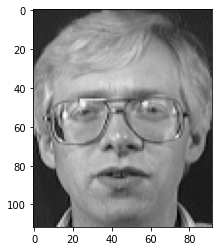

(92, 112, 1)
Starting Image:


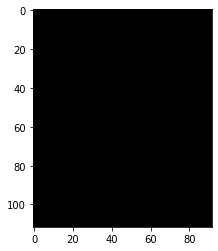

Current Loss: 6.0843577
Updated Image:


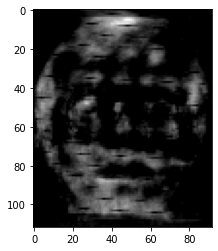

Noise:


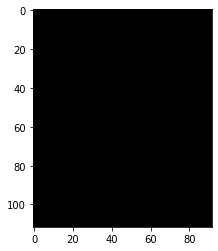

(92, 112, 1)
Starting Image:


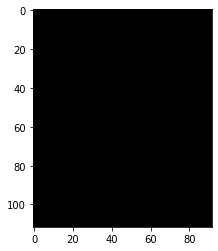

Current Loss: 6.0843577
Updated Image:


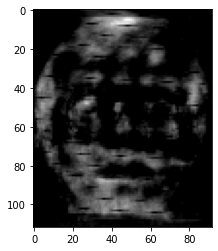

Noise:


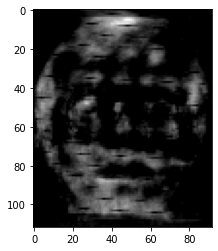

(92, 112, 1)
Starting Image:


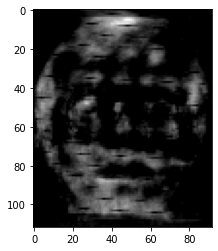

Current Loss: 30.887053
Updated Image:


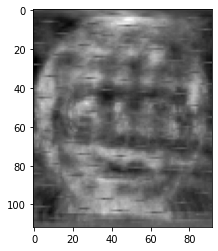

Noise:


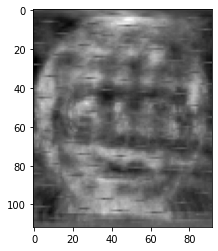

(92, 112, 1)
Starting Image:


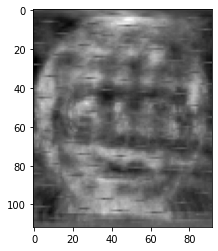

Current Loss: 105.37077
Updated Image:


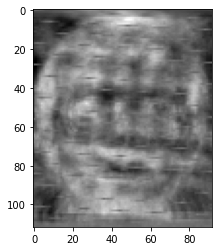

Noise:


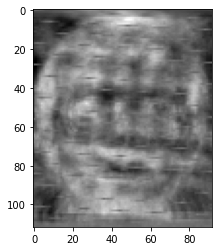

(92, 112, 1)
Starting Image:


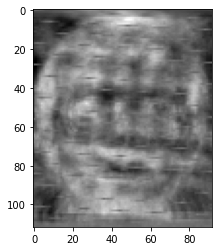

Current Loss: 182.22458
Updated Image:


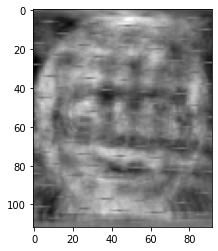

Noise:


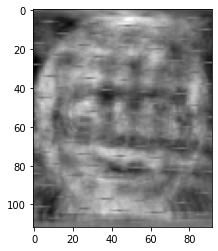

(92, 112, 1)
Starting Image:


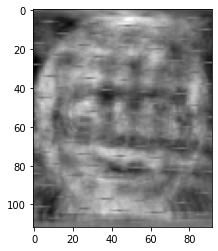

Current Loss: 230.26932
Updated Image:


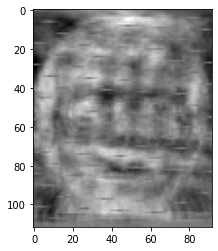

Noise:


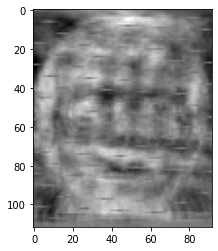

(92, 112, 1)
Starting Image:


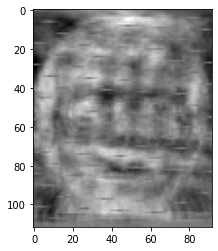

Current Loss: 283.511
Updated Image:


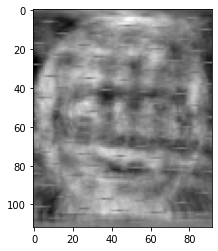

Noise:


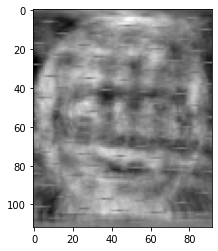

(92, 112, 1)
Starting Image:


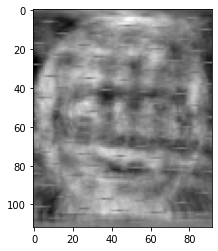

Current Loss: 417.1371
Updated Image:


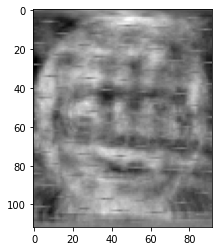

Noise:


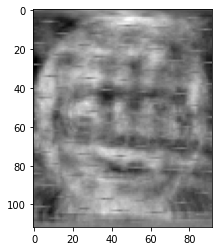

(92, 112, 1)
Starting Image:


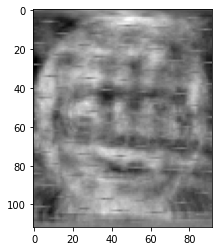

Current Loss: 423.61078
Updated Image:


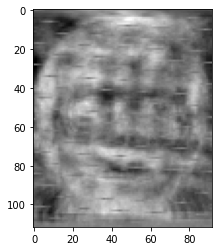

Noise:


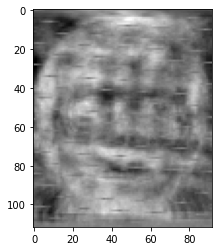

(92, 112, 1)
Starting Image:


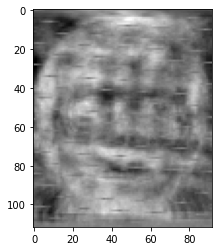

Current Loss: 525.2566
Updated Image:


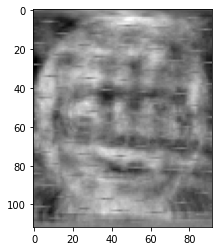

Noise:


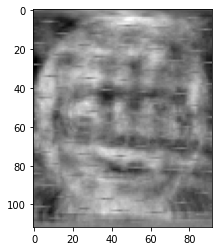

In [15]:
import tensorflow as tf

def sarahsinversion(model, img, learning_rate, label, best_loss, best_img, counter):
    print(img[0].shape)
    show_img_label(tf.reshape(img[0], (IMG_Y_SIZE, IMG_X_SIZE)), "Starting Image:")
    with tf.GradientTape() as tape:
        tape.watch(img)
        prediction = model(img, training=False) # run img through the model
        loss = loss_object(label, prediction) # calculate the loss of img
    gradient = tape.gradient(loss, img) # calculate the gradient with respect two each pixel in img
    print("Current Loss:", loss.numpy())
    
    img = tf.clip_by_value(img - learning_rate*gradient, 0, 255)
    show_img_label(tf.reshape(img[0], (IMG_Y_SIZE, IMG_X_SIZE)), "Updated Image:")
    

    
    
    img = np.array([np.clip(x+np.random.normal(2,2), 0, 255) for x in img.numpy()])
    show_img_label(tf.reshape(img[0], (IMG_Y_SIZE, IMG_X_SIZE)), "Noise:")
    img = tf.convert_to_tensor(img)
    return img


black_image_tensor = tf.convert_to_tensor(np.zeros((1,IMG_X_SIZE,IMG_Y_SIZE,1)))

for name_index in range(len(names)):
    if names[name_index] == "s2":
        print("Decoding: ", names[name_index])
        show_img_label(tf.reshape(XT[name_index], (IMG_Y_SIZE, IMG_X_SIZE)), "Goal Image:")
        best_img = black_image_tensor
        best_loss = float('inf')
        for i in range(10):
            best_img = sarahsinversion(model, best_img, 0.1, name_index, best_img, best_loss, i)
        break


